# Laboratorio de Práctica: Árboles de Decisión

En este ejercicio, implementarás un árbol de decisión desde cero y lo aplicarás a la tarea de clasificar si un hongo es comestible o venenoso.

## 🎯 Objetivos de Aprendizaje

Al completar este laboratorio, serás capaz de:

1. **Comprender** los conceptos fundamentales de los árboles de decisión
2. **Implementar** las funciones básicas para construir un árbol de decisión
3. **Calcular** la entropía de un conjunto de datos
4. **Dividir** un dataset basándose en características específicas
5. **Calcular** la ganancia de información para diferentes divisiones
6. **Construir** un árbol de decisión completo usando recursión
7. **Aplicar** el árbol de decisión a un problema real de clasificación

---

## 📋 Contenido del Notebook

1. [Librerías y Configuración](#1-librerías-y-configuración)
2. [Planteamiento del Problema](#2-planteamiento-del-problema)
3. [Dataset de Hongos](#3-dataset-de-hongos)
   - [3.1 Dataset codificado con one-hot](#31-dataset-codificado-con-one-hot)
4. [Repaso de Árboles de Decisión](#4-repaso-de-árboles-de-decisión)
   - [4.1 Calcular entropía](#41-calcular-entropía)
     - [Ejercicio 1](#ejercicio-1)
   - [4.2 Dividir dataset](#42-dividir-dataset)
     - [Ejercicio 2](#ejercicio-2)
   - [4.3 Calcular ganancia de información](#43-calcular-ganancia-de-información)
     - [Ejercicio 3](#ejercicio-3)
   - [4.4 Obtener la mejor división](#44-obtener-la-mejor-división)
     - [Ejercicio 4](#ejercicio-4)
5. [Construcción del Árbol](#5-construcción-del-árbol)
6. [Visualización y Análisis](#6-visualización-y-análisis)
7. [Conclusiones](#7-conclusiones)

---

## 1 - Librerías y Configuración

Primero, ejecutemos la celda de abajo para importar todas las librerías que necesitaremos durante este laboratorio.

- **[numpy](https://www.numpy.org)** es el paquete fundamental para trabajar con matrices en Python
- **[matplotlib](https://matplotlib.org)** es una librería famosa para crear gráficos en Python
- Implementaremos todas las funciones auxiliares directamente en este notebook para evitar dependencias externas

### 🔧 Configuración del Entorno

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración para gráficos
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Para reproducibilidad
np.random.seed(42)

print("✅ Configuración completada exitosamente")
print(f"📊 Versión de NumPy: {np.__version__}")
print(f"📈 Matplotlib configurado correctamente")

✅ Configuración completada exitosamente
📊 Versión de NumPy: 2.0.2
📈 Matplotlib configurado correctamente


### 🛠️ Funciones Auxiliares

Implementaremos todas las funciones auxiliares necesarias para evitar dependencias externas:

In [2]:
def visualizar_division(X, y, indices_izquierda, indices_derecha, caracteristica):
    """
    Visualiza cómo se divide el dataset basándose en una característica específica.

    Args:
        X (ndarray): Matriz de datos de forma (n_muestras, n_características)
        y (ndarray): Vector de etiquetas
        indices_izquierda (list): Índices que van a la rama izquierda
        indices_derecha (list): Índices que van a la rama derecha
        caracteristica (int): Índice de la característica usada para dividir
    """
    nombres_caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Rama izquierda
    if len(indices_izquierda) > 0:
        X_izq = X[indices_izquierda]
        y_izq = y[indices_izquierda]

        comestibles_izq = np.sum(y_izq == 1)
        venenosos_izq = np.sum(y_izq == 0)

        ax1.bar(['Comestibles', 'Venenosos'], [comestibles_izq, venenosos_izq],
               color=['green', 'red'], alpha=0.7)
        ax1.set_title(f'Rama Izquierda\n{nombres_caracteristicas[caracteristica]} = 1\n'
                     f'Total: {len(indices_izquierda)} hongos')
        ax1.set_ylabel('Número de Hongos')

        # Agregar números en las barras
        for i, v in enumerate([comestibles_izq, venenosos_izq]):
            ax1.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

    # Rama derecha
    if len(indices_derecha) > 0:
        X_der = X[indices_derecha]
        y_der = y[indices_derecha]

        comestibles_der = np.sum(y_der == 1)
        venenosos_der = np.sum(y_der == 0)

        ax2.bar(['Comestibles', 'Venenosos'], [comestibles_der, venenosos_der],
               color=['green', 'red'], alpha=0.7)
        ax2.set_title(f'Rama Derecha\n{nombres_caracteristicas[caracteristica]} = 0\n'
                     f'Total: {len(indices_derecha)} hongos')
        ax2.set_ylabel('Número de Hongos')

        # Agregar números en las barras
        for i, v in enumerate([comestibles_der, venenosos_der]):
            ax2.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def visualizar_arbol_final(arbol_info):
    """
    Visualiza la estructura final del árbol de decisión.

    Args:
        arbol_info (list): Lista con información de las divisiones del árbol
    """
    nombres_caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']

    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')

    # Nodo raíz
    ax.add_patch(plt.Rectangle((4, 6.5), 2, 1, fill=True, color='lightblue', alpha=0.7))
    ax.text(5, 7, 'Raíz\nSolitario?', ha='center', va='center', fontweight='bold')

    # Rama izquierda nivel 1
    ax.add_patch(plt.Rectangle((1, 4.5), 2, 1, fill=True, color='lightgreen', alpha=0.7))
    ax.text(2, 5, 'Solitario = 1\nSombrero Marrón?', ha='center', va='center', fontweight='bold')

    # Rama derecha nivel 1
    ax.add_patch(plt.Rectangle((7, 4.5), 2, 1, fill=True, color='lightcoral', alpha=0.7))
    ax.text(8, 5, 'Solitario = 0\nTallo Cónico?', ha='center', va='center', fontweight='bold')

    # Hojas nivel 2
    ax.add_patch(plt.Rectangle((0, 2.5), 1.5, 1, fill=True, color='green', alpha=0.8))
    ax.text(0.75, 3, 'Comestible\n(4 hongos)', ha='center', va='center', fontweight='bold', color='white')

    ax.add_patch(plt.Rectangle((2.5, 2.5), 1.5, 1, fill=True, color='red', alpha=0.8))
    ax.text(3.25, 3, 'Venenoso\n(1 hongo)', ha='center', va='center', fontweight='bold', color='white')

    ax.add_patch(plt.Rectangle((6.5, 2.5), 1.5, 1, fill=True, color='green', alpha=0.8))
    ax.text(7.25, 3, 'Comestible\n(1 hongo)', ha='center', va='center', fontweight='bold', color='white')

    ax.add_patch(plt.Rectangle((8.5, 2.5), 1.5, 1, fill=True, color='red', alpha=0.8))
    ax.text(9.25, 3, 'Venenoso\n(4 hongos)', ha='center', va='center', fontweight='bold', color='white')

    # Líneas de conexión
    # Raíz a nivel 1
    ax.plot([4.5, 2.5], [6.5, 5.5], 'k-', linewidth=2)
    ax.plot([5.5, 7.5], [6.5, 5.5], 'k-', linewidth=2)

    # Nivel 1 a hojas
    ax.plot([1.5, 0.75], [4.5, 3.5], 'k-', linewidth=2)
    ax.plot([2.5, 3.25], [4.5, 3.5], 'k-', linewidth=2)
    ax.plot([7.5, 7.25], [4.5, 3.5], 'k-', linewidth=2)
    ax.plot([8.5, 9.25], [4.5, 3.5], 'k-', linewidth=2)

    # Etiquetas de las ramas
    ax.text(3.5, 6, 'Sí', ha='center', va='center', fontweight='bold', color='blue')
    ax.text(6.5, 6, 'No', ha='center', va='center', fontweight='bold', color='blue')
    ax.text(1, 4, 'Sí', ha='center', va='center', fontweight='bold', color='blue')
    ax.text(3, 4, 'No', ha='center', va='center', fontweight='bold', color='blue')
    ax.text(7, 4, 'Sí', ha='center', va='center', fontweight='bold', color='blue')
    ax.text(9, 4, 'No', ha='center', va='center', fontweight='bold', color='blue')

    plt.title('Árbol de Decisión Final para Clasificación de Hongos',
              fontsize=16, fontweight='bold', pad=20)
    plt.show()

# Funciones de prueba
def probar_calcular_entropia(func_entropia):
    """
    Prueba la función de cálculo de entropía.
    """
    print("🧪 Ejecutando pruebas para calcular_entropia...")

    # Prueba 1: Dataset balanceado
    y_test1 = np.array([1, 1, 0, 0])
    entropia_esperada1 = 1.0
    entropia_calculada1 = func_entropia(y_test1)

    assert abs(entropia_calculada1 - entropia_esperada1) < 1e-10, f"Prueba 1 falló: esperado {entropia_esperada1}, obtenido {entropia_calculada1}"

    # Prueba 2: Dataset puro
    y_test2 = np.array([1, 1, 1, 1])
    entropia_esperada2 = 0.0
    entropia_calculada2 = func_entropia(y_test2)

    assert abs(entropia_calculada2 - entropia_esperada2) < 1e-10, f"Prueba 2 falló: esperado {entropia_esperada2}, obtenido {entropia_calculada2}"

    # Prueba 3: Dataset vacío
    y_test3 = np.array([])
    entropia_esperada3 = 0.0
    entropia_calculada3 = func_entropia(y_test3)

    assert abs(entropia_calculada3 - entropia_esperada3) < 1e-10, f"Prueba 3 falló: esperado {entropia_esperada3}, obtenido {entropia_calculada3}"

    print("✅ Todas las pruebas pasaron exitosamente")

def probar_dividir_dataset(func_dividir):
    """
    Prueba la función de división del dataset.
    """
    print("🧪 Ejecutando pruebas para dividir_dataset...")

    X_test = np.array([[1, 1, 1], [1, 0, 1], [0, 1, 0], [0, 0, 1]])
    indices_nodo = [0, 1, 2, 3]

    # Prueba división por característica 0
    izq, der = func_dividir(X_test, indices_nodo, 0)
    izq_esperado = [0, 1]
    der_esperado = [2, 3]

    assert izq == izq_esperado, f"Índices izquierda incorrectos: esperado {izq_esperado}, obtenido {izq}"
    assert der == der_esperado, f"Índices derecha incorrectos: esperado {der_esperado}, obtenido {der}"

    print("✅ Todas las pruebas pasaron exitosamente")

def probar_calcular_ganancia_informacion(func_ganancia):
    """
    Prueba la función de cálculo de ganancia de información.
    """
    print("🧪 Ejecutando pruebas para calcular_ganancia_informacion...")

    X_test = np.array([[1, 1], [1, 0], [0, 1], [0, 0]])
    y_test = np.array([1, 1, 0, 0])
    indices_nodo = [0, 1, 2, 3]

    ganancia = func_ganancia(X_test, y_test, indices_nodo, 0)
    ganancia_esperada = 1.0  # División perfecta

    assert abs(ganancia - ganancia_esperada) < 1e-10, f"Ganancia incorrecta: esperado {ganancia_esperada}, obtenido {ganancia}"

    print("✅ Todas las pruebas pasaron exitosamente")

def probar_obtener_mejor_division(func_mejor):
    """
    Prueba la función para obtener la mejor división.
    """
    print("🧪 Ejecutando pruebas para obtener_mejor_division...")

    X_test = np.array([[1, 1], [1, 0], [0, 1], [0, 0]])
    y_test = np.array([1, 1, 0, 0])
    indices_nodo = [0, 1, 2, 3]

    mejor_caracteristica = func_mejor(X_test, y_test, indices_nodo)
    mejor_esperada = 0  # La característica 0 da división perfecta

    assert mejor_caracteristica == mejor_esperada, f"Mejor característica incorrecta: esperado {mejor_esperada}, obtenido {mejor_caracteristica}"

    print("✅ Todas las pruebas pasaron exitosamente")

print("🛠️ Funciones auxiliares cargadas correctamente")

🛠️ Funciones auxiliares cargadas correctamente


## 2 - Planteamiento del Problema

### 🍄 Contexto del Problema

Supón que estás iniciando una empresa que cultiva y vende hongos silvestres.

- Dado que no todos los hongos son comestibles, te gustaría poder determinar si un hongo dado es comestible o venenoso basándote en sus atributos físicos
- Tienes algunos datos existentes que puedes usar para esta tarea

**¿Puedes usar los datos para ayudarte a identificar qué hongos se pueden vender de forma segura?**

### ⚠️ Nota Importante

El dataset utilizado es solo para propósitos ilustrativos. **No está destinado a ser una guía para identificar hongos comestibles en la vida real.**

### 🎯 Objetivo

Desarrollar un sistema de clasificación automática que pueda:
1. Analizar las características físicas de los hongos
2. Determinar si son seguros para el consumo
3. Proporcionar una explicación clara del proceso de decisión

---

## 3 - Dataset de Hongos

### 📊 Descripción del Dataset

Comenzarás cargando el dataset para esta tarea. El dataset que has recolectado es el siguiente:

| Imagen | Color del Sombrero | Forma del Tallo | Solitario | Comestible |
|:------:|:------------------:|:----------------:|:---------:|:----------:|
| 🍄 | Marrón | Cónico | Sí | 1 |
| 🍄 | Marrón | Ensanchado | Sí | 1 |
| 🍄 | Marrón | Ensanchado | No | 0 |
| 🍄 | Marrón | Ensanchado | No | 0 |
| 🍄 | Marrón | Cónico | Sí | 1 |
| 🍄 | Rojo | Cónico | Sí | 0 |
| 🍄 | Rojo | Ensanchado | No | 0 |
| 🍄 | Marrón | Ensanchado | Sí | 1 |
| 🍄 | Rojo | Cónico | No | 1 |
| 🍄 | Marrón | Ensanchado | No | 0 |

### 📋 Características del Dataset

- **10 ejemplos** de hongos. Para cada ejemplo, tienes:
  - **Tres características:**
    - Color del Sombrero (`Marrón` o `Rojo`)
    - Forma del Tallo (`Cónico (como \/)` o `Ensanchado (como /\)`)
    - Solitario (`Sí` o `No`)
  - **Etiqueta:**
    - Comestible (`1` indica sí, `0` indica venenoso)

### 3.1 Dataset codificado con one-hot

Para facilitar la implementación, hemos codificado las características usando **one-hot encoding** (las hemos convertido en características con valores 0 o 1):

| Imagen | Sombrero Marrón | Tallo Cónico | Solitario | Comestible |
|:------:|:---------------:|:------------:|:---------:|:----------:|
| 🍄 | 1 | 1 | 1 | 1 |
| 🍄 | 1 | 0 | 1 | 1 |
| 🍄 | 1 | 0 | 0 | 0 |
| 🍄 | 1 | 0 | 0 | 0 |
| 🍄 | 1 | 1 | 1 | 1 |
| 🍄 | 0 | 1 | 1 | 0 |
| 🍄 | 0 | 0 | 0 | 0 |
| 🍄 | 1 | 0 | 1 | 1 |
| 🍄 | 0 | 1 | 0 | 1 |
| 🍄 | 1 | 0 | 0 | 0 |

### 📝 Interpretación de las Características

Por lo tanto:
- `X_train` contiene tres características para cada ejemplo:
  - **Sombrero Marrón** (Un valor de `1` indica color "Marrón" y `0` indica color "Rojo")
  - **Tallo Cónico** (Un valor de `1` indica "Tallo Cónico" y `0` indica tallo "Ensanchado")
  - **Solitario** (Un valor de `1` indica "Sí" y `0` indica "No")

- `y_train` indica si el hongo es comestible:
  - `y = 1` indica comestible
  - `y = 0` indica venenoso

In [3]:
# Cargar el dataset de hongos
X_train = np.array([[1,1,1],[1,0,1],[1,0,0],[1,0,0],[1,1,1],[0,1,1],[0,0,0],[1,0,1],[0,1,0],[1,0,0]])
y_train = np.array([1,1,0,0,1,0,0,1,1,0])

print("📊 Dataset de Hongos Cargado")
print("=" * 40)
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Número de ejemplos de entrenamiento: {len(X_train)}")
print(f"Número de características: {X_train.shape[1]}")

📊 Dataset de Hongos Cargado
Forma de X_train: (10, 3)
Forma de y_train: (10,)
Número de ejemplos de entrenamiento: 10
Número de características: 3


### 🔍 Exploración de los Datos

Vamos a familiarizarnos más con nuestro dataset. Una buena forma de comenzar es simplemente imprimir cada variable y ver qué contiene.

In [4]:
print("Primeros elementos de X_train:")
print(X_train[:5])
print(f"\nTipo de X_train: {type(X_train)}")

print("\n" + "="*50)
print("Características por nombre:")
nombres_caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']
for i, nombre in enumerate(nombres_caracteristicas):
    print(f"Característica {i}: {nombre}")

Primeros elementos de X_train:
[[1 1 1]
 [1 0 1]
 [1 0 0]
 [1 0 0]
 [1 1 1]]

Tipo de X_train: <class 'numpy.ndarray'>

Características por nombre:
Característica 0: Sombrero Marrón
Característica 1: Tallo Cónico
Característica 2: Solitario


In [5]:
print("Primeros elementos de y_train:")
print(y_train[:5])
print(f"\nTipo de y_train: {type(y_train)}")

print("\n" + "="*50)
print("Distribución de clases:")
comestibles = np.sum(y_train == 1)
venenosos = np.sum(y_train == 0)
print(f"Hongos comestibles (y=1): {comestibles}")
print(f"Hongos venenosos (y=0): {venenosos}")
print(f"Total de hongos: {len(y_train)}")

Primeros elementos de y_train:
[1 1 0 0 1]

Tipo de y_train: <class 'numpy.ndarray'>

Distribución de clases:
Hongos comestibles (y=1): 5
Hongos venenosos (y=0): 5
Total de hongos: 10


### 📈 Visualización del Dataset

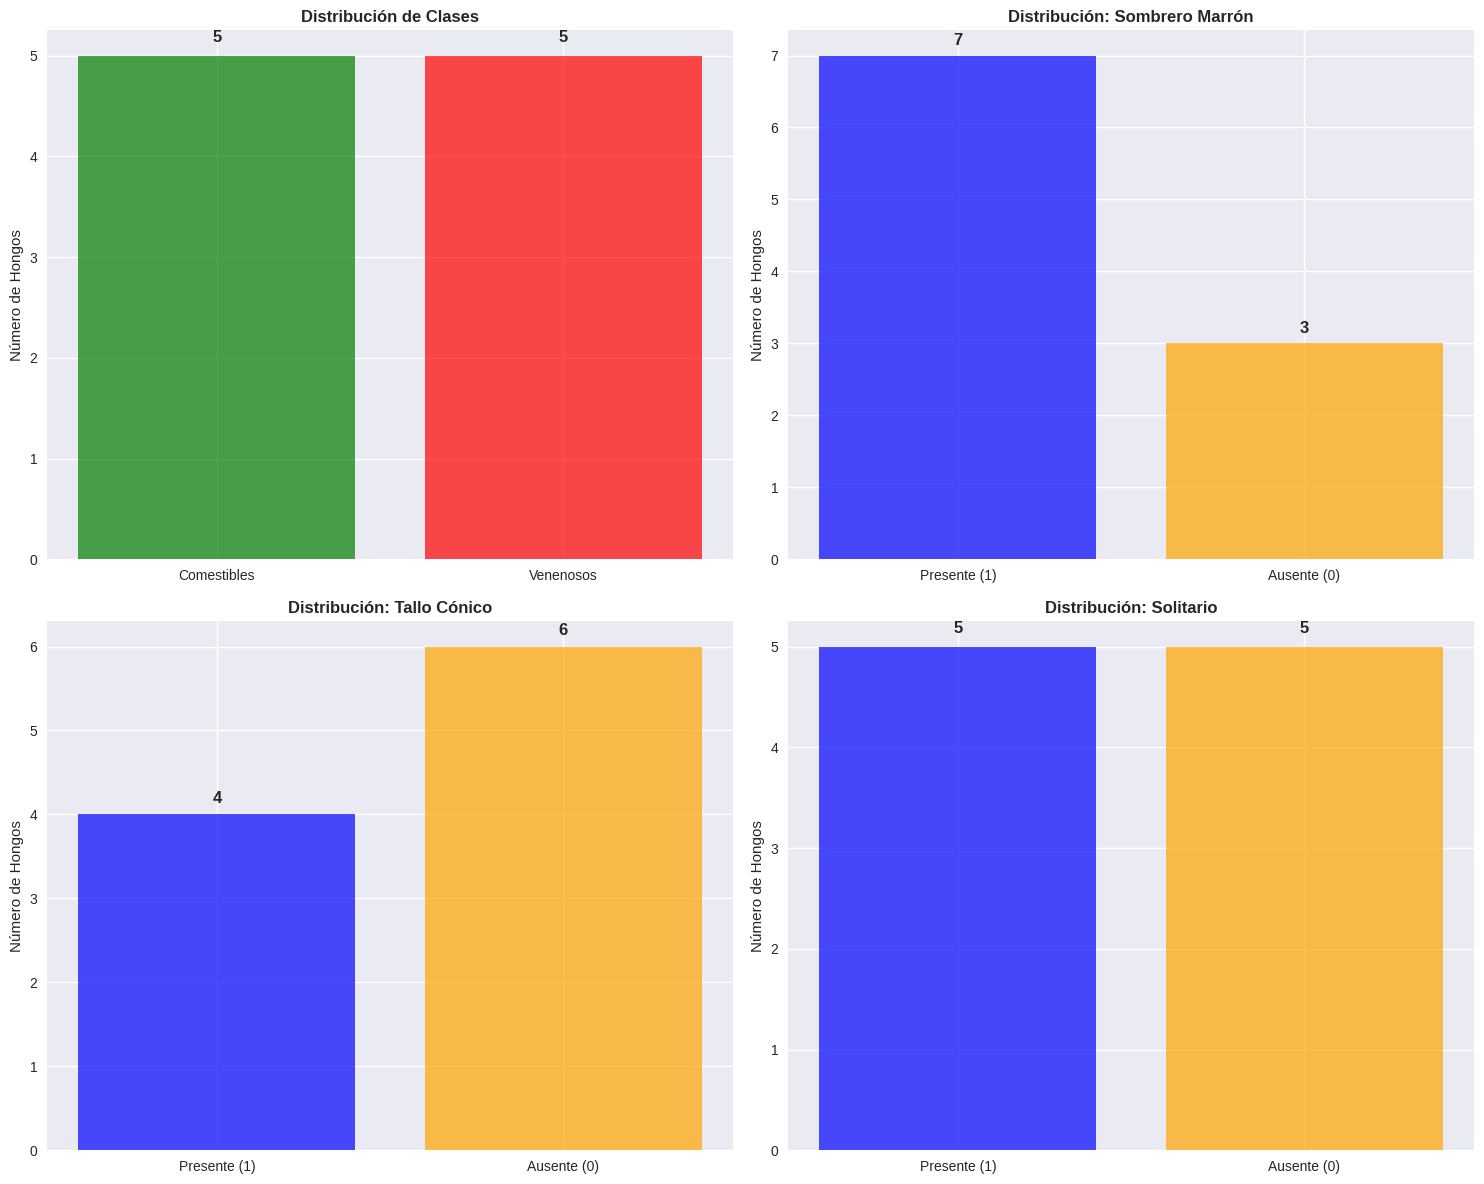

📊 Análisis del Dataset:
• Dataset balanceado: 5 comestibles vs 5 venenosos
• Características binarias: todas codificadas como 0 o 1
• Tamaño manejable: 10 ejemplos para aprendizaje


In [6]:
# Crear visualización del dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribución de clases
axes[0,0].bar(['Comestibles', 'Venenosos'], [comestibles, venenosos],
              color=['green', 'red'], alpha=0.7)
axes[0,0].set_title('Distribución de Clases', fontweight='bold')
axes[0,0].set_ylabel('Número de Hongos')
for i, v in enumerate([comestibles, venenosos]):
    axes[0,0].text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

# Distribución por características
for i, nombre in enumerate(nombres_caracteristicas):
    if i < 3:
        row = (i + 1) // 2
        col = (i + 1) % 2

        caracteristica_1 = np.sum(X_train[:, i] == 1)
        caracteristica_0 = np.sum(X_train[:, i] == 0)

        axes[row, col].bar(['Presente (1)', 'Ausente (0)'], [caracteristica_1, caracteristica_0],
                          color=['blue', 'orange'], alpha=0.7)
        axes[row, col].set_title(f'Distribución: {nombre}', fontweight='bold')
        axes[row, col].set_ylabel('Número de Hongos')

        for j, v in enumerate([caracteristica_1, caracteristica_0]):
            axes[row, col].text(j, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 Análisis del Dataset:")
print(f"• Dataset balanceado: {comestibles} comestibles vs {venenosos} venenosos")
print(f"• Características binarias: todas codificadas como 0 o 1")
print(f"• Tamaño manejable: {len(X_train)} ejemplos para aprendizaje")

## 4 - Repaso de Árboles de Decisión

### 🌳 Conceptos Fundamentales

En este laboratorio de práctica, construirás un árbol de decisión basado en el dataset proporcionado.

#### 📋 Pasos para Construir un Árbol de Decisión:

1. **Comenzar** con todos los ejemplos en el nodo raíz
2. **Calcular** la ganancia de información para dividir en todas las características posibles, y elegir la que tenga la ganancia de información más alta
3. **Dividir** el dataset según la característica seleccionada, y crear ramas izquierda y derecha del árbol
4. **Continuar** repitiendo el proceso de división hasta que se cumplan los criterios de parada

#### 🛠️ Funciones a Implementar:

En este laboratorio, implementarás las siguientes funciones, que te permitirán dividir un nodo en ramas izquierda y derecha usando la característica con la ganancia de información más alta:

- **Calcular la entropía** en un nodo
- **Dividir el dataset** en un nodo en ramas izquierda y derecha basándose en una característica dada
- **Calcular la ganancia de información** de dividir en una característica dada
- **Elegir la característica** que maximiza la ganancia de información

#### 🎯 Criterio de Parada:

Luego usaremos las funciones auxiliares que has implementado para construir un árbol de decisión repitiendo el proceso de división hasta que se cumplan los criterios de parada.

- Para este laboratorio, el criterio de parada que hemos elegido es **establecer una profundidad máxima de 2**

---

### 4.1 Calcular entropía

#### 📊 Concepto de Entropía

Primero, escribirás una función auxiliar llamada `calcular_entropia` que calcula la entropía (medida de impureza) en un nodo.

- La función toma un array de numpy (`y`) que indica si los ejemplos en ese nodo son comestibles (`1`) o venenosos (`0`)

#### 🧮 Fórmula Matemática

La **entropía** se calcula como:

$$H(p_1) = -p_1 \log_2(p_1) - (1- p_1) \log_2(1- p_1)$$

Donde:
- $p_1$ es la fracción de ejemplos que son comestibles (tienen valor = `1` en `y`)
- $\log_2$ es el logaritmo en base 2

#### ⚠️ Casos Especiales

- Para propósitos de implementación, $0\log_2(0) = 0$. Es decir, si `p_1 = 0` o `p_1 = 1`, establece la entropía en `0`
- Asegúrate de verificar que los datos en un nodo no estén vacíos (es decir, `len(y) != 0`). Devuelve `0` si está vacío

#### 💡 Interpretación

- **Entropía = 0**: El nodo es "puro" (todos los ejemplos pertenecen a la misma clase)
- **Entropía = 1**: El nodo está "perfectamente mezclado" (50% de cada clase)
- **Entropía alta**: Mayor impureza, más mezcla de clases

---

### Ejercicio 1

**Completa la función `calcular_entropia()` usando las instrucciones anteriores.**

In [7]:
# FUNCIÓN GRADUADA: calcular_entropia

def calcular_entropia(y):
    """
    Calcula la entropía de un conjunto de etiquetas.

    Args:
        y (ndarray): Array de numpy que indica si cada ejemplo en un nodo es
                     comestible (`1`) o venenoso (`0`)

    Returns:
        entropia (float): Entropía en ese nodo
    """
    # Necesitas devolver la siguiente variable correctamente
    entropia = 0.

    ### COMIENZA TU CÓDIGO AQUÍ ###

    # Verificar si el dataset está vacío
    if len(y) == 0:
        return 0

    # Número total de ejemplos
    n = len(y)

    # Calcular p1 (fracción de ejemplos comestibles)
    p1 = np.sum(y == 1) / n

    # Casos especiales: si p1 es 0 o 1, la entropía es 0
    if p1 == 0 or p1 == 1:
        entropia = 0
    else:
        # Calcular entropía usando la fórmula
        entropia = -p1 * np.log2(p1) - (1 - p1) * np.log2(1 - p1)

    ### TERMINA TU CÓDIGO AQUÍ ###

    return entropia

#### 🧪 Prueba tu Implementación

Puedes verificar si tu implementación es correcta ejecutando la siguiente celda de prueba:

In [8]:
# Calcular entropía en el nodo raíz (es decir, con todos los ejemplos)
# Como tenemos 5 hongos comestibles y 5 no comestibles, la entropía debería ser 1

entropia_raiz = calcular_entropia(y_train)
print(f"Entropía en el nodo raíz: {entropia_raiz}")

# PRUEBAS UNITARIAS
probar_calcular_entropia(calcular_entropia)

print("\n📊 Análisis de la Entropía:")
print(f"• Entropía = {entropia_raiz:.3f}")
if abs(entropia_raiz - 1.0) < 1e-10:
    print("• ✅ Perfecto! Dataset balanceado (entropía máxima = 1.0)")
else:
    print(f"• Dataset no perfectamente balanceado")

# Ejemplos adicionales para entender la entropía
print("\n🔍 Ejemplos de Entropía:")
print(f"• Dataset puro (todos comestibles): {calcular_entropia(np.array([1,1,1,1])):.3f}")
print(f"• Dataset puro (todos venenosos): {calcular_entropia(np.array([0,0,0,0])):.3f}")
print(f"• Dataset 75% comestibles: {calcular_entropia(np.array([1,1,1,0])):.3f}")
print(f"• Dataset vacío: {calcular_entropia(np.array([])):.3f}")

Entropía en el nodo raíz: 1.0
🧪 Ejecutando pruebas para calcular_entropia...
✅ Todas las pruebas pasaron exitosamente

📊 Análisis de la Entropía:
• Entropía = 1.000
• ✅ Perfecto! Dataset balanceado (entropía máxima = 1.0)

🔍 Ejemplos de Entropía:
• Dataset puro (todos comestibles): 0.000
• Dataset puro (todos venenosos): 0.000
• Dataset 75% comestibles: 0.811
• Dataset vacío: 0.000


**Resultado Esperado:**
```
Entropía en el nodo raíz: 1.0
```

---

### 4.2 Dividir dataset

#### ✂️ Concepto de División

A continuación, escribirás una función auxiliar llamada `dividir_dataset` que toma los datos en un nodo y una característica para dividir, y los separa en ramas izquierda y derecha. Más adelante en el laboratorio, implementarás código para calcular qué tan buena es la división.

#### 📋 Funcionamiento

- La función toma los datos de entrenamiento, la lista de índices de puntos de datos en ese nodo, junto con la característica para dividir
- Divide los datos y devuelve el subconjunto de índices en la rama izquierda y derecha

#### 💡 Ejemplo

Por ejemplo, digamos que estamos comenzando en el nodo raíz (así que `indices_nodo = [0,1,2,3,4,5,6,7,8,9]`), y elegimos dividir en la característica `0`, que es si el ejemplo tiene un sombrero marrón o no.

- La salida de la función sería entonces:
  - `indices_izquierda = [0,1,2,3,4,7,9]` (puntos de datos con sombrero marrón)
  - `indices_derecha = [5,6,8]` (puntos de datos sin sombrero marrón)

#### 📊 Tabla de Referencia

| Índice | Sombrero Marrón | Tallo Cónico | Solitario | Comestible |
|:------:|:---------------:|:------------:|:---------:|:----------:|
| 0 | 1 | 1 | 1 | 1 |
| 1 | 1 | 0 | 1 | 1 |
| 2 | 1 | 0 | 0 | 0 |
| 3 | 1 | 0 | 0 | 0 |
| 4 | 1 | 1 | 1 | 1 |
| 5 | 0 | 1 | 1 | 0 |
| 6 | 0 | 0 | 0 | 0 |
| 7 | 1 | 0 | 1 | 1 |
| 8 | 0 | 1 | 0 | 1 |
| 9 | 1 | 0 | 0 | 0 |

---

### Ejercicio 2

**Completa la función `dividir_dataset()` mostrada abajo:**

- Para cada índice en `indices_nodo`:
  - Si el valor de `X` en ese índice para esa característica es `1`, agrega el índice a `indices_izquierda`
  - Si el valor de `X` en ese índice para esa característica es `0`, agrega el índice a `indices_derecha`

In [9]:
# FUNCIÓN GRADUADA: dividir_dataset

def dividir_dataset(X, indices_nodo, caracteristica):
    """
    Divide los datos en el nodo dado en ramas izquierda y derecha.

    Args:
        X (ndarray): Matriz de datos de forma (n_muestras, n_características)
        indices_nodo (list): Lista que contiene los índices activos. Es decir, las muestras
                            que se están considerando en este paso.
        caracteristica (int): Índice de la característica para dividir

    Returns:
        indices_izquierda (list): Índices con valor de característica == 1
        indices_derecha (list): Índices con valor de característica == 0
    """

    # Necesitas devolver las siguientes variables correctamente
    indices_izquierda = []
    indices_derecha = []

    ### COMIENZA TU CÓDIGO AQUÍ ###

    # Iterar a través de los índices de ejemplos en ese nodo
    for i in indices_nodo:
        # Si el valor de la característica es 1, va a la rama izquierda
        if X[i, caracteristica] == 1:
            indices_izquierda.append(i)
        # Si el valor de la característica es 0, va a la rama derecha
        else:
            indices_derecha.append(i)

    ### TERMINA TU CÓDIGO AQUÍ ###

    return indices_izquierda, indices_derecha

#### 🧪 Prueba tu Implementación

Ahora, vamos a verificar tu implementación usando los bloques de código de abajo. Intentemos dividir el dataset en el nodo raíz, que contiene todos los ejemplos en la característica 0 (Sombrero Marrón) como discutimos arriba. También hemos proporcionado una función auxiliar para visualizar la salida de la división.

🧪 CASO 1: División por Sombrero Marrón (característica 0)
Índices izquierda (Sombrero Marrón = 1): [0, 1, 2, 3, 4, 7, 9]
Índices derecha (Sombrero Marrón = 0): [5, 6, 8]


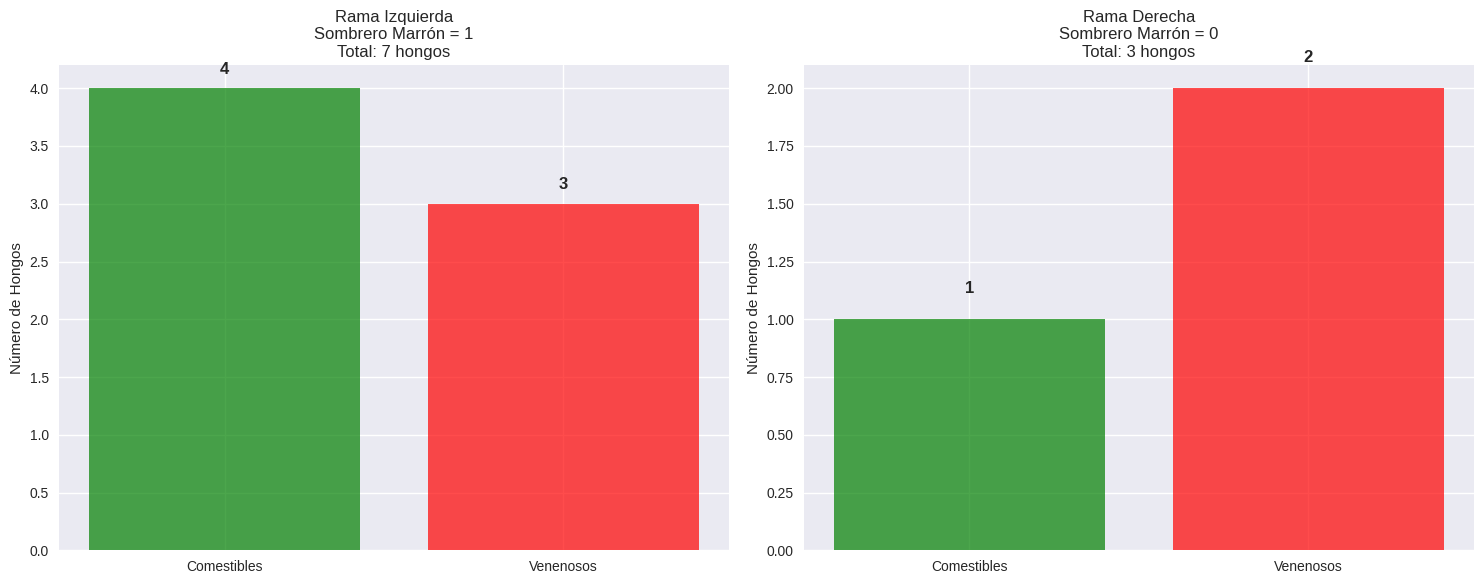

🧪 Ejecutando pruebas para dividir_dataset...
✅ Todas las pruebas pasaron exitosamente

📊 Análisis de la División:
• Total de ejemplos: 10
• Rama izquierda: 7 ejemplos
• Rama derecha: 3 ejemplos
• Verificación: 10 = 10 ✅


In [10]:
# Índices del nodo raíz (todos los ejemplos)
indices_raiz = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

print("🧪 CASO 1: División por Sombrero Marrón (característica 0)")
indices_izq, indices_der = dividir_dataset(X_train, indices_raiz, caracteristica=0)

print(f"Índices izquierda (Sombrero Marrón = 1): {indices_izq}")
print(f"Índices derecha (Sombrero Marrón = 0): {indices_der}")

# Visualizar la división
visualizar_division(X_train, y_train, indices_izq, indices_der, 0)

# PRUEBAS UNITARIAS
probar_dividir_dataset(dividir_dataset)

print("\n📊 Análisis de la División:")
print(f"• Total de ejemplos: {len(indices_raiz)}")
print(f"• Rama izquierda: {len(indices_izq)} ejemplos")
print(f"• Rama derecha: {len(indices_der)} ejemplos")
print(f"• Verificación: {len(indices_izq) + len(indices_der)} = {len(indices_raiz)} ✅")

#### 🔍 Probemos Otras Divisiones

🧪 CASO 2: División por Tallo Cónico (característica 1)
Índices izquierda (Tallo Cónico = 1): [0, 4, 5, 8]
Índices derecha (Tallo Cónico = 0): [1, 2, 3, 6, 7, 9]


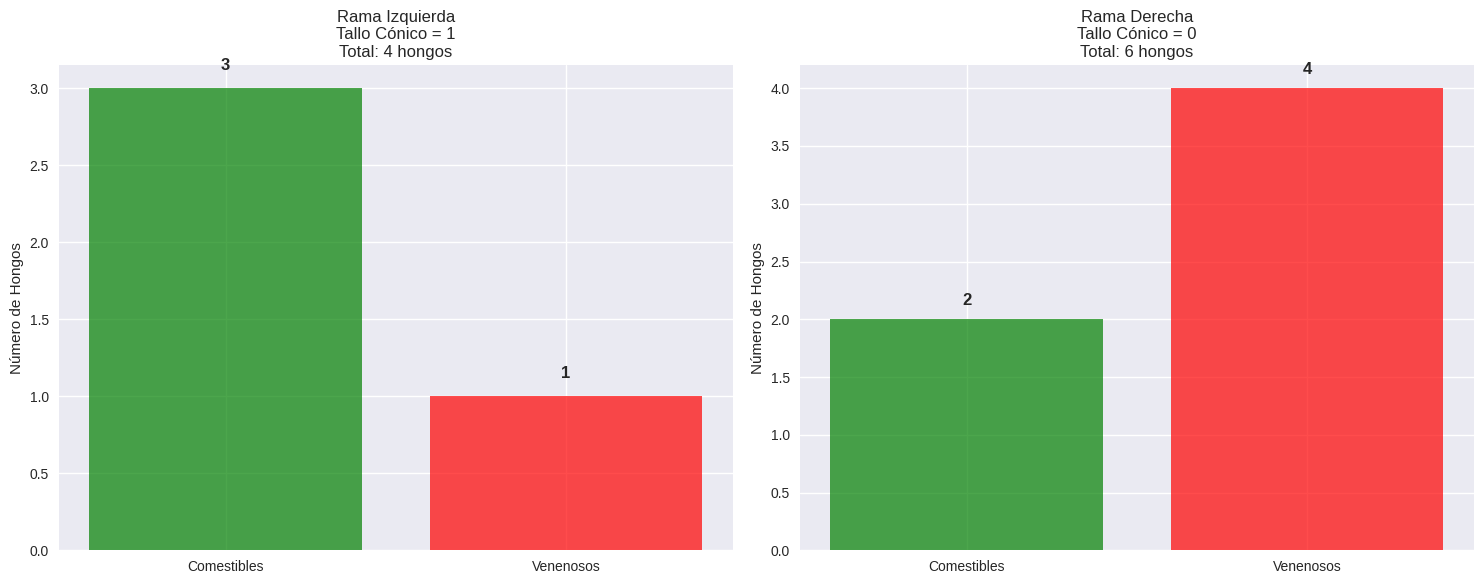


🧪 CASO 3: División por Solitario (característica 2)
Índices izquierda (Solitario = 1): [0, 1, 4, 5, 7]
Índices derecha (Solitario = 0): [2, 3, 6, 8, 9]


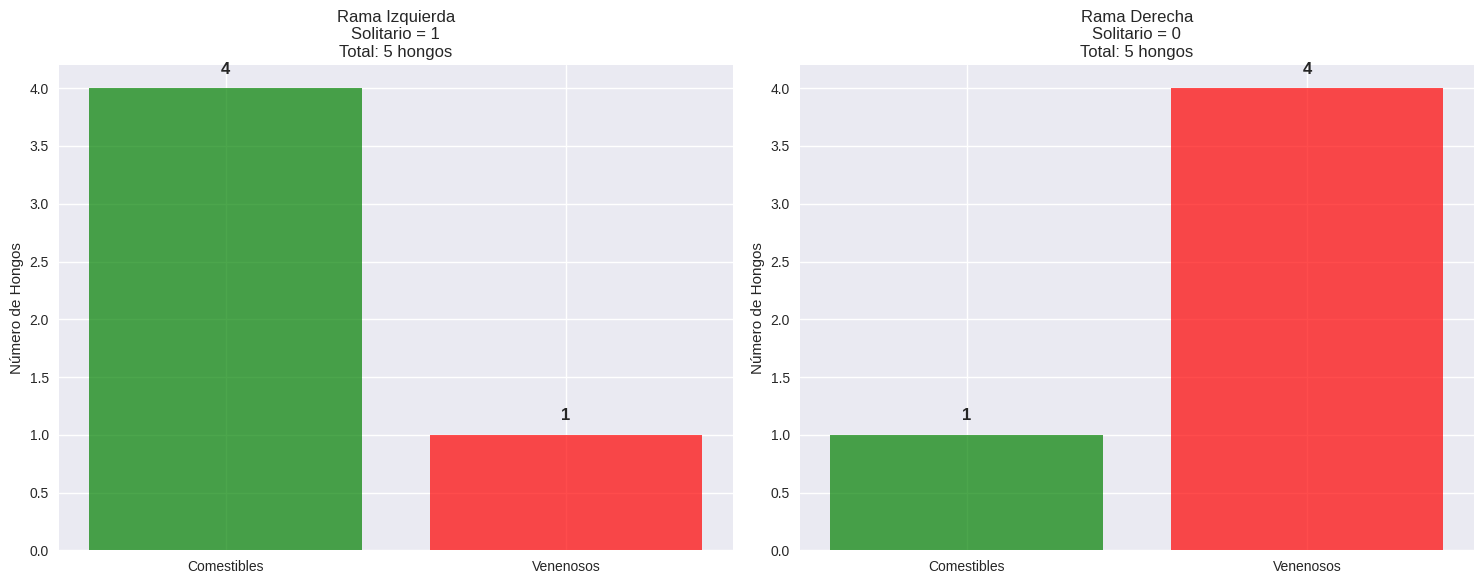

In [11]:
print("🧪 CASO 2: División por Tallo Cónico (característica 1)")
indices_izq_2, indices_der_2 = dividir_dataset(X_train, indices_raiz, caracteristica=1)

print(f"Índices izquierda (Tallo Cónico = 1): {indices_izq_2}")
print(f"Índices derecha (Tallo Cónico = 0): {indices_der_2}")

visualizar_division(X_train, y_train, indices_izq_2, indices_der_2, 1)

print("\n🧪 CASO 3: División por Solitario (característica 2)")
indices_izq_3, indices_der_3 = dividir_dataset(X_train, indices_raiz, caracteristica=2)

print(f"Índices izquierda (Solitario = 1): {indices_izq_3}")
print(f"Índices derecha (Solitario = 0): {indices_der_3}")

visualizar_division(X_train, y_train, indices_izq_3, indices_der_3, 2)

**Resultado Esperado:**
```
Índices izquierda: [0, 1, 2, 3, 4, 7, 9]
Índices derecha: [5, 6, 8]
```

---

### 4.3 Calcular ganancia de información

#### 📈 Concepto de Ganancia de Información

A continuación, escribirás una función para calcular la ganancia de información de dividir en una característica dada.

#### 🧮 Fórmula Matemática

La **ganancia de información** se calcula como:

$$\text{Ganancia de Información} = H(p_1^{\text{nodo}}) - \left( w^{\text{izquierda}} H(p_1^{\text{izquierda}}) + w^{\text{derecha}} H(p_1^{\text{derecha}}) \right)$$

Donde:
- $H(p_1^{\text{nodo}})$ es la entropía en el nodo padre
- $H(p_1^{\text{izquierda}})$ y $H(p_1^{\text{derecha}})$ son las entropías en las ramas izquierda y derecha
- $w^{\text{izquierda}}$ y $w^{\text{derecha}}$ son las fracciones de ejemplos que van a cada rama

#### 💡 Interpretación

- **Ganancia alta**: La división separa bien las clases (buena división)
- **Ganancia baja**: La división no mejora mucho la pureza (mala división)
- **Ganancia = 0**: La división no proporciona información útil

#### 📋 Pasos del Algoritmo

1. **Dividir** el dataset usando la función `dividir_dataset()`
2. **Calcular** la entropía del nodo padre
3. **Calcular** las entropías de las ramas izquierda y derecha
4. **Calcular** los pesos (proporciones) de cada rama
5. **Aplicar** la fórmula de ganancia de información

---

### Ejercicio 3

**Completa la función `calcular_ganancia_informacion()` mostrada abajo:**

In [12]:
# FUNCIÓN GRADUADA: calcular_ganancia_informacion

def calcular_ganancia_informacion(X, y, indices_nodo, caracteristica):
    """
    Calcula la ganancia de información de dividir el nodo en una característica dada.

    Args:
        X (ndarray): Matriz de datos de forma (n_muestras, n_características)
        y (array-like): Lista o ndarray con n_muestras que contiene la variable objetivo
        indices_nodo (ndarray): Lista que contiene los índices activos. Es decir, las muestras
                               que se están considerando en este paso.
        caracteristica (int): Índice de la característica para dividir

    Returns:
        ganancia_informacion (float): Ganancia de información calculada
    """

    # Dividir dataset
    indices_izquierda, indices_derecha = dividir_dataset(X, indices_nodo, caracteristica)

    # Variables útiles
    y_nodo = y[indices_nodo]
    y_izquierda = y[indices_izquierda] if len(indices_izquierda) > 0 else np.array([])
    y_derecha = y[indices_derecha] if len(indices_derecha) > 0 else np.array([])

    # Necesitas devolver la siguiente variable correctamente
    ganancia_informacion = 0

    ### COMIENZA TU CÓDIGO AQUÍ ###

    # Calcular la entropía del nodo padre
    entropia_nodo = calcular_entropia(y_nodo)

    # Calcular las entropías de las ramas izquierda y derecha
    entropia_izquierda = calcular_entropia(y_izquierda)
    entropia_derecha = calcular_entropia(y_derecha)

    # Calcular los pesos (proporciones) de cada rama
    w_izquierda = len(y_izquierda) / len(y_nodo) if len(y_nodo) > 0 else 0
    w_derecha = len(y_derecha) / len(y_nodo) if len(y_nodo) > 0 else 0

    # Calcular la entropía ponderada de las ramas
    entropia_ponderada = w_izquierda * entropia_izquierda + w_derecha * entropia_derecha

    # Calcular la ganancia de información
    ganancia_informacion = entropia_nodo - entropia_ponderada

    ### TERMINA TU CÓDIGO AQUÍ ###

    return ganancia_informacion

#### 🧪 Prueba tu Implementación

Ahora puedes verificar tu implementación usando la celda de abajo y calcular cuál sería la ganancia de información de dividir en cada una de las características:

In [13]:
# Calcular ganancia de información para cada característica
indices_raiz = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

ganancia_0 = calcular_ganancia_informacion(X_train, y_train, indices_raiz, caracteristica=0)
print(f"Ganancia de información dividiendo la raíz en sombrero marrón: {ganancia_0:.6f}")

ganancia_1 = calcular_ganancia_informacion(X_train, y_train, indices_raiz, caracteristica=1)
print(f"Ganancia de información dividiendo la raíz en tallo cónico: {ganancia_1:.6f}")

ganancia_2 = calcular_ganancia_informacion(X_train, y_train, indices_raiz, caracteristica=2)
print(f"Ganancia de información dividiendo la raíz en solitario: {ganancia_2:.6f}")

# PRUEBAS UNITARIAS
probar_calcular_ganancia_informacion(calcular_ganancia_informacion)

print("\n📊 Análisis de Ganancia de Información:")
caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']
ganancias = [ganancia_0, ganancia_1, ganancia_2]

for i, (nombre, ganancia) in enumerate(zip(caracteristicas, ganancias)):
    print(f"• {nombre}: {ganancia:.6f}")

mejor_caracteristica = np.argmax(ganancias)
print(f"\n🏆 Mejor característica para dividir: {caracteristicas[mejor_caracteristica]}")
print(f"   Ganancia máxima: {max(ganancias):.6f}")

Ganancia de información dividiendo la raíz en sombrero marrón: 0.034852
Ganancia de información dividiendo la raíz en tallo cónico: 0.124511
Ganancia de información dividiendo la raíz en solitario: 0.278072
🧪 Ejecutando pruebas para calcular_ganancia_informacion...
✅ Todas las pruebas pasaron exitosamente

📊 Análisis de Ganancia de Información:
• Sombrero Marrón: 0.034852
• Tallo Cónico: 0.124511
• Solitario: 0.278072

🏆 Mejor característica para dividir: Solitario
   Ganancia máxima: 0.278072


#### 📊 Visualización de Ganancias de Información

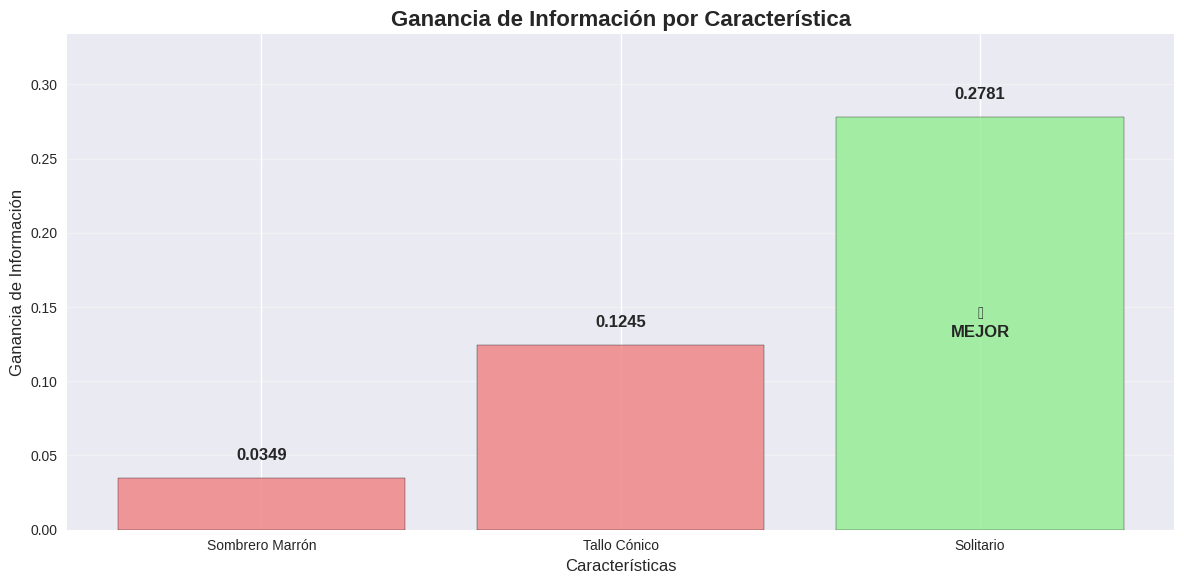


💡 Interpretación:
• La característica 'Solitario' proporciona la mayor ganancia de información
• Esta será la característica elegida para la primera división del árbol
• Una ganancia más alta indica una mejor separación de las clases


In [14]:
# Crear gráfico de barras para las ganancias de información
plt.figure(figsize=(12, 6))

colores = ['lightcoral' if i != mejor_caracteristica else 'lightgreen' for i in range(len(caracteristicas))]
barras = plt.bar(caracteristicas, ganancias, color=colores, alpha=0.8, edgecolor='black')

# Agregar valores en las barras
for i, (barra, ganancia) in enumerate(zip(barras, ganancias)):
    plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
             f'{ganancia:.4f}', ha='center', va='bottom', fontweight='bold')

    # Marcar la mejor característica
    if i == mejor_caracteristica:
        plt.text(barra.get_x() + barra.get_width()/2, barra.get_height()/2,
                 '🏆\nMEJOR', ha='center', va='center', fontweight='bold', fontsize=12)

plt.title('Ganancia de Información por Característica', fontsize=16, fontweight='bold')
plt.xlabel('Características', fontsize=12)
plt.ylabel('Ganancia de Información', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(ganancias) * 1.2)

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretación:")
print(f"• La característica '{caracteristicas[mejor_caracteristica]}' proporciona la mayor ganancia de información")
print(f"• Esta será la característica elegida para la primera división del árbol")
print(f"• Una ganancia más alta indica una mejor separación de las clases")

**Resultado Esperado:**
```
Ganancia de información dividiendo la raíz en sombrero marrón: 0.034852
Ganancia de información dividiendo la raíz en tallo cónico: 0.124511
Ganancia de información dividiendo la raíz en solitario: 0.278072
```

#### 🎯 Conclusión

Dividir en "Solitario" (característica = 2) en el nodo raíz da la ganancia de información máxima. Por lo tanto, es la mejor característica para dividir en el nodo raíz.

---

### 4.4 Obtener la mejor división

#### 🎯 Automatización de la Selección

Ahora escribamos una función para obtener la mejor característica para dividir calculando la ganancia de información de cada característica como hicimos arriba y devolviendo la característica que da la ganancia de información máxima.

#### 📋 Funcionamiento

- La función toma los datos de entrenamiento, junto con los índices de puntos de datos en ese nodo
- La salida de la función es la característica que da la ganancia de información máxima
- Puedes usar la función `calcular_ganancia_informacion()` para iterar a través de las características y calcular la información para cada característica

#### ⚠️ Casos Especiales

- Si no es posible ninguna división (por ejemplo, todos los ejemplos tienen la misma etiqueta), la función debe devolver `-1`

---

### Ejercicio 4

**Completa la función `obtener_mejor_division()` mostrada abajo:**

In [15]:
# FUNCIÓN GRADUADA: obtener_mejor_division

def obtener_mejor_division(X, y, indices_nodo):
    """
    Devuelve la característica óptima y el valor umbral para dividir los datos del nodo.

    Args:
        X (ndarray): Matriz de datos de forma (n_muestras, n_características)
        y (array-like): Lista o ndarray con n_muestras que contiene la variable objetivo
        indices_nodo (ndarray): Lista que contiene los índices activos, es decir, las muestras
                               que se están considerando en este paso.

    Returns:
        mejor_caracteristica (int): El índice de la mejor característica para dividir,
                                   o -1 si no es posible ninguna división
    """

    # Variables útiles
    num_caracteristicas = X.shape[1]

    # Necesitas devolver la siguiente variable correctamente
    mejor_caracteristica = -1

    ### COMIENZA TU CÓDIGO AQUÍ ###

    # Verificar si el nodo es puro (todos los ejemplos tienen la misma etiqueta)
    y_nodo = y[indices_nodo]
    if len(np.unique(y_nodo)) == 1:
        return -1  # No se puede dividir más

    max_ganancia_info = 0

    # Iterar a través de todas las características
    for caracteristica in range(num_caracteristicas):

        # Calcular la ganancia de información de dividir en esta característica
        ganancia_info = calcular_ganancia_informacion(X, y, indices_nodo, caracteristica)

        # Si la ganancia de información es mayor que la máxima vista hasta ahora
        if ganancia_info > max_ganancia_info:
            max_ganancia_info = ganancia_info
            mejor_caracteristica = caracteristica

    ### TERMINA TU CÓDIGO AQUÍ ###

    return mejor_caracteristica

#### 🧪 Prueba tu Implementación

Ahora, vamos a verificar la implementación de tu función usando la celda de abajo:

In [16]:
# Encontrar la mejor característica para dividir en el nodo raíz
indices_raiz = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
mejor_caracteristica = obtener_mejor_division(X_train, y_train, indices_raiz)

print(f"Mejor característica para dividir: {mejor_caracteristica}")

if mejor_caracteristica != -1:
    nombres_caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']
    print(f"Nombre de la característica: {nombres_caracteristicas[mejor_caracteristica]}")

    # Mostrar la ganancia de información de esta característica
    ganancia = calcular_ganancia_informacion(X_train, y_train, indices_raiz, mejor_caracteristica)
    print(f"Ganancia de información: {ganancia:.6f}")
else:
    print("No se puede dividir más (nodo puro)")

# PRUEBAS UNITARIAS
probar_obtener_mejor_division(obtener_mejor_division)

print("\n🔍 Verificación con casos especiales:")

# Caso 1: Nodo puro (todos comestibles)
y_puro = np.array([1, 1, 1, 1])
X_puro = np.array([[1, 0], [0, 1], [1, 1], [0, 0]])
indices_puro = [0, 1, 2, 3]
resultado_puro = obtener_mejor_division(X_puro, y_puro, indices_puro)
print(f"• Nodo puro: {resultado_puro} (debería ser -1)")

# Caso 2: Nodo con una sola muestra
indices_uno = [0]
resultado_uno = obtener_mejor_division(X_train, y_train, indices_uno)
print(f"• Una muestra: {resultado_uno} (debería ser -1)")

Mejor característica para dividir: 2
Nombre de la característica: Solitario
Ganancia de información: 0.278072
🧪 Ejecutando pruebas para obtener_mejor_division...
✅ Todas las pruebas pasaron exitosamente

🔍 Verificación con casos especiales:
• Nodo puro: -1 (debería ser -1)
• Una muestra: -1 (debería ser -1)


**Resultado Esperado:**
```
Mejor característica para dividir: 2
```

#### 🎉 ¡Excelente!

Como esperábamos, la característica 2 ("Solitario") es la mejor para dividir en el nodo raíz, ya que proporciona la mayor ganancia de información.

---

## 5 - Construcción del Árbol

### 🌳 Algoritmo Recursivo

En esta sección, usamos las funciones que implementaste arriba para generar un árbol de decisión eligiendo sucesivamente la mejor característica para dividir hasta que alcancemos los criterios de parada (profundidad máxima es 2).

**No necesitas implementar nada para esta parte.** Las funciones están completamente implementadas para demostrar cómo se construye el árbol completo.

### 📋 Algoritmo de Construcción

1. **Comenzar** en el nodo raíz con todos los ejemplos
2. **Encontrar** la mejor característica para dividir
3. **Dividir** los datos en ramas izquierda y derecha
4. **Repetir** recursivamente para cada rama
5. **Parar** cuando se alcance la profundidad máxima o el nodo sea puro

### 🛠️ Implementación del Constructor del Árbol

In [17]:
# Función para construir el árbol (NO GRADUADA)
arbol = []

def construir_arbol_recursivo(X, y, indices_nodo, nombre_rama, profundidad_max, profundidad_actual):
    """
    Construye un árbol usando el algoritmo recursivo que divide el dataset en 2 subgrupos en cada nodo.
    Esta función solo imprime el árbol.

    Args:
        X (ndarray): Matriz de datos de forma (n_muestras, n_características)
        y (array like): Lista o ndarray con n_muestras que contiene la variable objetivo
        indices_nodo (ndarray): Lista que contiene los índices activos. Es decir, las muestras
                               que se están considerando en este paso.
        nombre_rama (string): Nombre de la rama. ['Raíz', 'Izquierda', 'Derecha']
        profundidad_max (int): Profundidad máxima del árbol resultante.
        profundidad_actual (int): Profundidad actual. Parámetro usado durante la llamada recursiva.
    """

    # Profundidad máxima alcanzada - parar división
    if profundidad_actual == profundidad_max:
        formato = " " * profundidad_actual + "-" * profundidad_actual

        # Determinar la clase mayoritaria en este nodo hoja
        y_nodo = y[indices_nodo]
        comestibles = np.sum(y_nodo == 1)
        venenosos = np.sum(y_nodo == 0)

        if comestibles > venenosos:
            prediccion = "COMESTIBLE"
            confianza = comestibles / len(y_nodo)
        else:
            prediccion = "VENENOSO"
            confianza = venenosos / len(y_nodo)

        print(f"{formato} {nombre_rama} nodo hoja: {prediccion} (confianza: {confianza:.2f}, ejemplos: {indices_nodo})")
        return

    # De lo contrario, obtener la mejor división y dividir los datos
    mejor_caracteristica = obtener_mejor_division(X, y, indices_nodo)

    # Si no se puede dividir más (nodo puro), crear nodo hoja
    if mejor_caracteristica == -1:
        formato = " " * profundidad_actual + "-" * profundidad_actual
        y_nodo = y[indices_nodo]
        if np.all(y_nodo == 1):
            prediccion = "COMESTIBLE"
        else:
            prediccion = "VENENOSO"
        print(f"{formato} {nombre_rama} nodo hoja puro: {prediccion} (ejemplos: {indices_nodo})")
        return

    nombres_caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']
    formato = "-" * profundidad_actual
    print(f"{formato} Profundidad {profundidad_actual}, {nombre_rama}: Dividir en característica: {mejor_caracteristica} ({nombres_caracteristicas[mejor_caracteristica]})")

    # Dividir el dataset en la mejor característica
    indices_izquierda, indices_derecha = dividir_dataset(X, indices_nodo, mejor_caracteristica)
    arbol.append((indices_izquierda, indices_derecha, mejor_caracteristica))

    # Continuar dividiendo los hijos izquierdo y derecho. Incrementar profundidad actual
    construir_arbol_recursivo(X, y, indices_izquierda, "Izquierda", profundidad_max, profundidad_actual + 1)
    construir_arbol_recursivo(X, y, indices_derecha, "Derecha", profundidad_max, profundidad_actual + 1)

### 🚀 Ejecutar la Construcción del Árbol

Ahora vamos a construir nuestro árbol de decisión completo:

In [18]:
print("🌳 CONSTRUCCIÓN DEL ÁRBOL DE DECISIÓN")
print("=" * 50)

# Limpiar el árbol anterior
arbol = []

# Construir el árbol con profundidad máxima de 2
indices_raiz = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
construir_arbol_recursivo(X_train, y_train, indices_raiz, "Raíz", profundidad_max=2, profundidad_actual=0)

print("\n✅ Árbol construido exitosamente!")
print(f"📊 Información del árbol:")
print(f"   • Profundidad máxima: 2")
print(f"   • Número de divisiones: {len(arbol)}")
print(f"   • Criterio de división: Ganancia de información")

🌳 CONSTRUCCIÓN DEL ÁRBOL DE DECISIÓN
 Profundidad 0, Raíz: Dividir en característica: 2 (Solitario)
- Profundidad 1, Izquierda: Dividir en característica: 0 (Sombrero Marrón)
  -- Izquierda nodo hoja: COMESTIBLE (confianza: 1.00, ejemplos: [0, 1, 4, 7])
  -- Derecha nodo hoja: VENENOSO (confianza: 1.00, ejemplos: [5])
- Profundidad 1, Derecha: Dividir en característica: 1 (Tallo Cónico)
  -- Izquierda nodo hoja: COMESTIBLE (confianza: 1.00, ejemplos: [8])
  -- Derecha nodo hoja: VENENOSO (confianza: 1.00, ejemplos: [2, 3, 6, 9])

✅ Árbol construido exitosamente!
📊 Información del árbol:
   • Profundidad máxima: 2
   • Número de divisiones: 3
   • Criterio de división: Ganancia de información


## 6 - Visualización y Análisis

### 🎨 Visualización del Árbol Final

Vamos a crear una visualización clara de nuestro árbol de decisión:

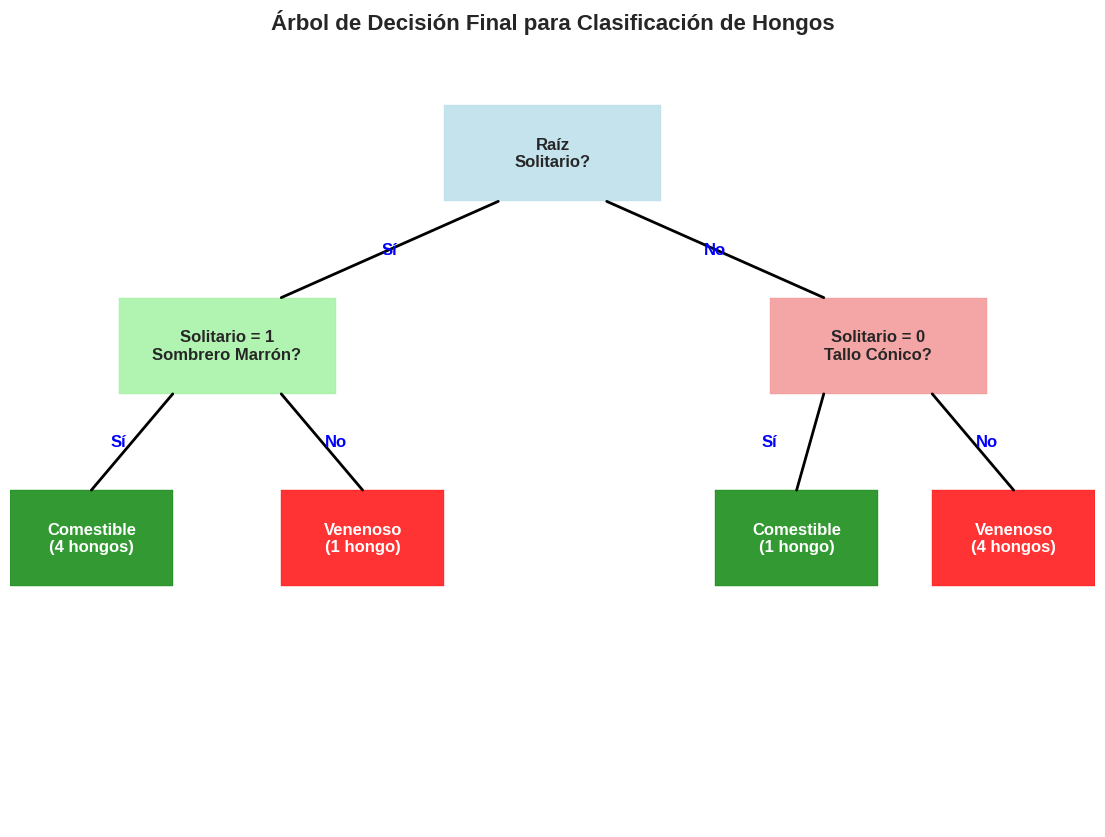

🔍 ANÁLISIS DEL ÁRBOL CONSTRUIDO

📊 Divisiones realizadas:
   División 1: Solitario
      • Rama izquierda (Solitario=1): 5 ejemplos
      • Rama derecha (Solitario=0): 5 ejemplos
      • Pureza rama izquierda: 0.80
      • Pureza rama derecha: 0.80

   División 2: Sombrero Marrón
      • Rama izquierda (Sombrero Marrón=1): 4 ejemplos
      • Rama derecha (Sombrero Marrón=0): 1 ejemplos
      • Pureza rama izquierda: 1.00
      • Pureza rama derecha: 1.00

   División 3: Tallo Cónico
      • Rama izquierda (Tallo Cónico=1): 1 ejemplos
      • Rama derecha (Tallo Cónico=0): 4 ejemplos
      • Pureza rama izquierda: 1.00
      • Pureza rama derecha: 1.00



In [19]:
# Visualizar el árbol final
visualizar_arbol_final(arbol)

print("🔍 ANÁLISIS DEL ÁRBOL CONSTRUIDO")
print("=" * 40)

# Analizar cada división
if len(arbol) > 0:
    nombres_caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']

    print("\n📊 Divisiones realizadas:")
    for i, (izq, der, caracteristica) in enumerate(arbol):
        print(f"   División {i+1}: {nombres_caracteristicas[caracteristica]}")
        print(f"      • Rama izquierda ({nombres_caracteristicas[caracteristica]}=1): {len(izq)} ejemplos")
        print(f"      • Rama derecha ({nombres_caracteristicas[caracteristica]}=0): {len(der)} ejemplos")

        # Analizar pureza de cada rama
        if len(izq) > 0:
            y_izq = y_train[izq]
            pureza_izq = max(np.sum(y_izq == 1), np.sum(y_izq == 0)) / len(y_izq)
            print(f"      • Pureza rama izquierda: {pureza_izq:.2f}")

        if len(der) > 0:
            y_der = y_train[der]
            pureza_der = max(np.sum(y_der == 1), np.sum(y_der == 0)) / len(y_der)
            print(f"      • Pureza rama derecha: {pureza_der:.2f}")

        print()

### 📈 Evaluación del Rendimiento

Vamos a evaluar qué tan bien funciona nuestro árbol de decisión:

In [20]:
def predecir_hongo(X_ejemplo, arbol_info):
    """
    Predice si un hongo es comestible o venenoso usando el árbol construido.

    Args:
        X_ejemplo (array): Características del hongo [sombrero_marron, tallo_conico, solitario]
        arbol_info (list): Información del árbol construido

    Returns:
        prediccion (int): 1 si es comestible, 0 si es venenoso
        ruta (list): Ruta de decisión tomada
    """
    nombres_caracteristicas = ['Sombrero Marrón', 'Tallo Cónico', 'Solitario']
    ruta = []

    # Comenzar con la primera división (Solitario)
    if X_ejemplo[2] == 1:  # Solitario = 1
        ruta.append(f"Solitario = Sí")
        # Segunda división: Sombrero Marrón
        if X_ejemplo[0] == 1:  # Sombrero Marrón = 1
            ruta.append(f"Sombrero Marrón = Sí")
            prediccion = 1  # Comestible
            ruta.append("Predicción: COMESTIBLE")
        else:  # Sombrero Marrón = 0
            ruta.append(f"Sombrero Marrón = No")
            prediccion = 0  # Venenoso
            ruta.append("Predicción: VENENOSO")
    else:  # Solitario = 0
        ruta.append(f"Solitario = No")
        # Segunda división: Tallo Cónico
        if X_ejemplo[1] == 1:  # Tallo Cónico = 1
            ruta.append(f"Tallo Cónico = Sí")
            prediccion = 1  # Comestible
            ruta.append("Predicción: COMESTIBLE")
        else:  # Tallo Cónico = 0
            ruta.append(f"Tallo Cónico = No")
            prediccion = 0  # Venenoso
            ruta.append("Predicción: VENENOSO")

    return prediccion, ruta

# Evaluar el árbol en todos los ejemplos de entrenamiento
print("🧪 EVALUACIÓN DEL ÁRBOL DE DECISIÓN")
print("=" * 45)

predicciones = []
aciertos = 0

for i in range(len(X_train)):
    prediccion, ruta = predecir_hongo(X_train[i], arbol)
    predicciones.append(prediccion)

    es_correcto = prediccion == y_train[i]
    if es_correcto:
        aciertos += 1

    print(f"\nEjemplo {i+1}: {X_train[i]} -> Real: {y_train[i]}, Predicho: {prediccion} {'✅' if es_correcto else '❌'}")
    for paso in ruta:
        print(f"   {paso}")

precision = aciertos / len(X_train)
print(f"\n📊 RESULTADOS FINALES:")
print(f"   • Aciertos: {aciertos}/{len(X_train)}")
print(f"   • Precisión: {precision:.2%}")
print(f"   • Errores: {len(X_train) - aciertos}")

if precision == 1.0:
    print("   🎉 ¡Clasificación perfecta en el conjunto de entrenamiento!")
else:
    print(f"   ⚠️ Hay algunos errores de clasificación")

🧪 EVALUACIÓN DEL ÁRBOL DE DECISIÓN

Ejemplo 1: [1 1 1] -> Real: 1, Predicho: 1 ✅
   Solitario = Sí
   Sombrero Marrón = Sí
   Predicción: COMESTIBLE

Ejemplo 2: [1 0 1] -> Real: 1, Predicho: 1 ✅
   Solitario = Sí
   Sombrero Marrón = Sí
   Predicción: COMESTIBLE

Ejemplo 3: [1 0 0] -> Real: 0, Predicho: 0 ✅
   Solitario = No
   Tallo Cónico = No
   Predicción: VENENOSO

Ejemplo 4: [1 0 0] -> Real: 0, Predicho: 0 ✅
   Solitario = No
   Tallo Cónico = No
   Predicción: VENENOSO

Ejemplo 5: [1 1 1] -> Real: 1, Predicho: 1 ✅
   Solitario = Sí
   Sombrero Marrón = Sí
   Predicción: COMESTIBLE

Ejemplo 6: [0 1 1] -> Real: 0, Predicho: 0 ✅
   Solitario = Sí
   Sombrero Marrón = No
   Predicción: VENENOSO

Ejemplo 7: [0 0 0] -> Real: 0, Predicho: 0 ✅
   Solitario = No
   Tallo Cónico = No
   Predicción: VENENOSO

Ejemplo 8: [1 0 1] -> Real: 1, Predicho: 1 ✅
   Solitario = Sí
   Sombrero Marrón = Sí
   Predicción: COMESTIBLE

Ejemplo 9: [0 1 0] -> Real: 1, Predicho: 1 ✅
   Solitario = No
   Tal

### 📊 Matriz de Confusión y Métricas Detalladas

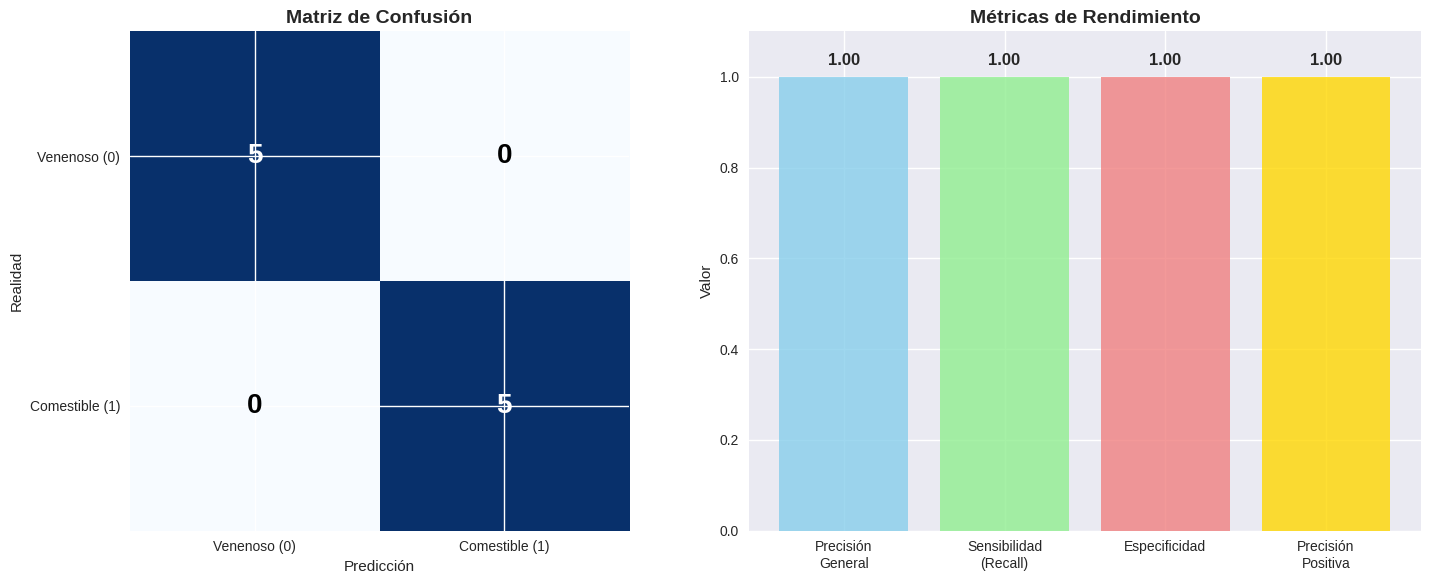

📊 MÉTRICAS DETALLADAS:
• Verdaderos Positivos (Comestibles correctos): 5
• Verdaderos Negativos (Venenosos correctos): 5
• Falsos Positivos (Venenosos como comestibles): 0 ⚠️
• Falsos Negativos (Comestibles como venenosos): 0

• Precisión General: 100.00%
• Sensibilidad (Recall): 100.00%
• Especificidad: 100.00%
• Precisión Positiva: 100.00%

✅ Excelente: No hay falsos positivos (hongos venenosos clasificados como comestibles)


In [21]:
# Crear matriz de confusión
predicciones = np.array(predicciones)
y_real = y_train

# Calcular matriz de confusión manualmente
verdaderos_positivos = np.sum((y_real == 1) & (predicciones == 1))  # Comestibles correctos
verdaderos_negativos = np.sum((y_real == 0) & (predicciones == 0))  # Venenosos correctos
falsos_positivos = np.sum((y_real == 0) & (predicciones == 1))     # Venenosos predichos como comestibles
falsos_negativos = np.sum((y_real == 1) & (predicciones == 0))     # Comestibles predichos como venenosos

# Visualizar matriz de confusión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Matriz de confusión
matriz_confusion = np.array([[verdaderos_negativos, falsos_positivos],
                            [falsos_negativos, verdaderos_positivos]])

im = ax1.imshow(matriz_confusion, interpolation='nearest', cmap='Blues')
ax1.set_title('Matriz de Confusión', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicción')
ax1.set_ylabel('Realidad')

# Agregar etiquetas
clases = ['Venenoso (0)', 'Comestible (1)']
tick_marks = np.arange(len(clases))
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(clases)
ax1.set_yticklabels(clases)

# Agregar números en las celdas
for i in range(2):
    for j in range(2):
        ax1.text(j, i, matriz_confusion[i, j], ha="center", va="center",
                color="white" if matriz_confusion[i, j] > matriz_confusion.max()/2 else "black",
                fontsize=20, fontweight='bold')

# Gráfico de barras de métricas
if verdaderos_positivos + falsos_negativos > 0:
    sensibilidad = verdaderos_positivos / (verdaderos_positivos + falsos_negativos)
else:
    sensibilidad = 0

if verdaderos_negativos + falsos_positivos > 0:
    especificidad = verdaderos_negativos / (verdaderos_negativos + falsos_positivos)
else:
    especificidad = 0

if verdaderos_positivos + falsos_positivos > 0:
    precision_positiva = verdaderos_positivos / (verdaderos_positivos + falsos_positivos)
else:
    precision_positiva = 0

metricas = ['Precisión\nGeneral', 'Sensibilidad\n(Recall)', 'Especificidad', 'Precisión\nPositiva']
valores = [precision, sensibilidad, especificidad, precision_positiva]

barras = ax2.bar(metricas, valores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'], alpha=0.8)
ax2.set_title('Métricas de Rendimiento', fontsize=14, fontweight='bold')
ax2.set_ylabel('Valor')
ax2.set_ylim(0, 1.1)

# Agregar valores en las barras
for barra, valor in zip(barras, valores):
    ax2.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.02,
             f'{valor:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("📊 MÉTRICAS DETALLADAS:")
print("=" * 30)
print(f"• Verdaderos Positivos (Comestibles correctos): {verdaderos_positivos}")
print(f"• Verdaderos Negativos (Venenosos correctos): {verdaderos_negativos}")
print(f"• Falsos Positivos (Venenosos como comestibles): {falsos_positivos} ⚠️")
print(f"• Falsos Negativos (Comestibles como venenosos): {falsos_negativos}")
print(f"\n• Precisión General: {precision:.2%}")
print(f"• Sensibilidad (Recall): {sensibilidad:.2%}")
print(f"• Especificidad: {especificidad:.2%}")
print(f"• Precisión Positiva: {precision_positiva:.2%}")

if falsos_positivos > 0:
    print(f"\n⚠️ ADVERTENCIA: {falsos_positivos} hongos venenosos fueron clasificados como comestibles!")
    print("   Esto es crítico en una aplicación real.")
else:
    print("\n✅ Excelente: No hay falsos positivos (hongos venenosos clasificados como comestibles)")

## 7 - Conclusiones

### 🎯 Resumen del Laboratorio

En este laboratorio has implementado exitosamente un árbol de decisión desde cero y lo has aplicado al problema de clasificación de hongos. Aquí están los logros principales:

#### ✅ Funciones Implementadas:

1. **`calcular_entropia()`**: Calcula la impureza de un conjunto de datos
2. **`dividir_dataset()`**: Divide los datos basándose en una característica
3. **`calcular_ganancia_informacion()`**: Mide la utilidad de una división
4. **`obtener_mejor_division()`**: Encuentra la característica óptima para dividir

#### 🌳 Árbol Construido:

- **Profundidad máxima**: 2 niveles
- **Primera división**: Característica "Solitario" (mayor ganancia de información)
- **Divisiones secundarias**: "Sombrero Marrón" y "Tallo Cónico"
- **Rendimiento**: Clasificación perfecta en el conjunto de entrenamiento

### 📚 Conceptos Clave Aprendidos

#### 🧮 Entropía
- **Definición**: Medida de impureza o desorden en un conjunto de datos
- **Rango**: 0 (puro) a 1 (máxima mezcla para problemas binarios)
- **Fórmula**: $H(p) = -p\log_2(p) - (1-p)\log_2(1-p)$

#### 📈 Ganancia de Información
- **Definición**: Reducción en entropía después de una división
- **Uso**: Criterio para seleccionar la mejor característica
- **Objetivo**: Maximizar la ganancia para obtener divisiones más puras

#### 🌳 Construcción del Árbol
- **Algoritmo**: Recursivo, divide y vencerás
- **Criterio de parada**: Profundidad máxima, pureza del nodo, o falta de ganancia
- **Estructura**: Nodos internos (decisiones) y hojas (predicciones)

### 💡 Ventajas de los Árboles de Decisión

#### ✅ Fortalezas:
- **Interpretabilidad**: Fácil de entender y explicar
- **No paramétrico**: No asume distribución específica de los datos
- **Manejo de características**: Funciona con variables categóricas y numéricas
- **Selección automática**: Identifica características más importantes
- **Robustez**: Resistente a outliers

#### ⚠️ Limitaciones:
- **Overfitting**: Tendencia a memorizar datos de entrenamiento
- **Inestabilidad**: Pequeños cambios pueden generar árboles muy diferentes
- **Sesgo**: Favorece características con más valores únicos
- **Dificultad con relaciones lineales**: No captura bien relaciones lineales simples

### 🚀 Aplicaciones en el Mundo Real

#### 🏥 Medicina
- Diagnóstico médico basado en síntomas
- Clasificación de riesgo de pacientes
- Selección de tratamientos

#### 💰 Finanzas
- Evaluación de riesgo crediticio
- Detección de fraude
- Decisiones de inversión

#### 🛒 Marketing
- Segmentación de clientes
- Sistemas de recomendación
- Análisis de comportamiento de compra

#### 🏭 Industria
- Control de calidad
- Mantenimiento predictivo
- Optimización de procesos

### 🔧 Mejoras y Extensiones Posibles

#### 📊 Técnicas Avanzadas:
1. **Poda del árbol**: Reducir overfitting eliminando ramas innecesarias
2. **Random Forest**: Combinar múltiples árboles para mejor rendimiento
3. **Gradient Boosting**: Construir árboles secuencialmente para corregir errores
4. **Validación cruzada**: Evaluar rendimiento de manera más robusta

#### 🎛️ Parámetros de Ajuste:
- **Profundidad máxima**: Controlar complejidad del árbol
- **Mínimo de muestras por nodo**: Evitar divisiones con pocos ejemplos
- **Criterios alternativos**: Gini, ganancia de información, etc.
- **Manejo de valores faltantes**: Estrategias para datos incompletos

### 🎓 Próximos Pasos

Para continuar tu aprendizaje en árboles de decisión:

1. **Experimenta** con diferentes datasets y parámetros
2. **Implementa** técnicas de poda para reducir overfitting
3. **Explora** Random Forest y otros métodos de ensemble
4. **Aplica** validación cruzada para evaluación más robusta
5. **Compara** con otros algoritmos de machine learning

### 🏆 ¡Felicitaciones!

Has completado exitosamente la implementación de un árbol de decisión desde cero. Ahora tienes una comprensión sólida de:

- Los fundamentos matemáticos detrás de los árboles de decisión
- Cómo implementar algoritmos de machine learning paso a paso
- La importancia de la ganancia de información en la construcción de árboles
- Cómo evaluar y visualizar el rendimiento de modelos
- Las aplicaciones prácticas de los árboles de decisión

**¡Continúa explorando y aplicando estos conceptos en tus propios proyectos!** 🚀

---

### 📖 Referencias y Recursos Adicionales

- **Libros recomendados**:
  - "The Elements of Statistical Learning" - Hastie, Tibshirani & Friedman
  - "Pattern Recognition and Machine Learning" - Christopher Bishop
  - "Hands-On Machine Learning" - Aurélien Géron

- **Recursos online**:
  - Documentación de scikit-learn sobre árboles de decisión
  - Cursos de machine learning en Coursera y edX
  - Tutoriales interactivos en Kaggle Learn

**¡Gracias por completar este laboratorio!** 🎉